# Trading by Prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# load our modules
import sys
sys.path.append("../../")
import lstm
import profit

## Load Data

We again consider the Tesla stock of the latest 90 days.

In [2]:
stocks: pd.DataFrame = pd.read_csv("../../data/stocks.csv", index_col=0, parse_dates=True)
company = "TSLA"
stock = stocks.query(f"Company == '{company}'").drop(columns=["Company", "Sector"])
num_days = 90
stock = stock[-num_days:]
stock

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-27,249.366669,252.070007,242.566666,244.919998,89178300
2022-06-28,244.483337,249.970001,232.343338,232.663330,90391200
2022-06-29,230.500000,231.173340,222.273331,228.490005,82897200
2022-06-30,224.509995,229.456665,218.863327,224.473328,94600500
2022-07-01,227.000000,230.229996,222.119995,227.263336,74460300
...,...,...,...,...,...
2022-10-26,219.399994,230.600006,218.199997,224.639999,85012500
2022-10-27,229.770004,233.809998,222.850006,225.089996,61638800
2022-10-28,225.399994,228.860001,216.350006,228.520004,69152400


## Load Trained Model

Recall that to use our `PricePredictor`, we need a feature encoder.

In [3]:
# set up feature encoder for the price predictor
feature_encoder = LabelEncoder()
feature_encoder.fit(lstm.ALL_FEATURES)

LabelEncoder()

Pass the encoder to the class attribute:

In [4]:
lstm.PricePredictor.feature_encoder = feature_encoder

Convert Pandas `DataFrame` to NumPy array:

In [5]:
# select the features of interest in data frame and transform it to NumPy array
stock = stock[lstm.ALL_FEATURES]
ts = stock[feature_encoder.classes_].to_numpy()

Load our trained model with `joblib` module:

```{note}
In fact, Scikit-Learn recommends to use `joblib` to load the models instead of `pickle` module.
```

In [6]:
price_predictor = joblib.load("../../models/TSLA-3-day-predictor.pkl")
price_predictor

PricePredictor(features=['Open', 'Volume', 'Close'], hidden_size=16,
               num_days_ago=400, pred_len=3, seq_len=30)

## Information About the Stock Price of Future 1, 2 or 3 Days

In this notebook, we choose to refer the predicted closing price the day after tomorrow. (`num_days_ahead` equals 2.)

In [7]:
num_days_ahead = 2

For each day, what the model does is that it takes into consideration all past days before the current day and predict the closing price N days from now. (N equals `num_days_ahead`. Since the model we have loaded can predict at most 3 days ahead, N can only be 1, 2 or 3.)

In [8]:
# use price predictor to predict future prices
sliding_prices = price_predictor.predict(ts)
future_prices = sliding_prices[1:, num_days_ahead-1]

# compare current and future closing prices
stock = stock.copy()[["Close"]]
stock["Future"] = future_prices

stock

,Close,Future
Date,,
2022-06-27,244.919998,245.929047
2022-06-28,232.663330,243.220215
2022-06-29,228.490005,237.126190
2022-06-30,224.473328,231.133057
2022-07-01,227.263336,229.120163
...,...,...
2022-10-26,224.639999,219.918671
2022-10-27,225.089996,223.878922
2022-10-28,228.520004,226.528946


## Strategy

The strategy is rather straight forward. 
- If the future price drops, and we are holding some shares, then we must sell all of it.
- If the future price rises, and we don't have any shares, then it is a good time to buy.

In [9]:
# Find buying and selling dates
buy_dates = []
sell_dates = []
is_holding_shares = False
for date, row in stock.iterrows():
    if is_holding_shares:
        # price will go down, sell it!
        if row["Future"] < row["Close"]:
            sell_dates.append(date)
            is_holding_shares = False
    else:
        # price will go up, buy!
        if row["Future"] > row["Close"]:
            buy_dates.append(date)
            is_holding_shares = True

# convert to Pandas `DatetimeIndex`
buy_dates = pd.DatetimeIndex(buy_dates)
sell_dates = pd.DatetimeIndex(sell_dates)

buy_dates, sell_dates

(DatetimeIndex(['2022-06-27', '2022-07-11', '2022-07-18', '2022-07-20',
                '2022-07-25', '2022-08-01', '2022-08-11', '2022-08-17',
                '2022-08-26', '2022-09-02', '2022-09-13', '2022-09-20',
                '2022-09-29', '2022-10-05', '2022-10-07', '2022-10-14',
                '2022-10-20', '2022-10-24', '2022-10-31'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2022-07-05', '2022-07-14', '2022-07-19', '2022-07-21',
                '2022-07-29', '2022-08-10', '2022-08-12', '2022-08-23',
                '2022-09-01', '2022-09-06', '2022-09-19', '2022-09-26',
                '2022-10-04', '2022-10-06', '2022-10-12', '2022-10-17',
                '2022-10-21', '2022-10-25'],
               dtype='datetime64[ns]', freq=None))

We now visualize the buying and selling dates:

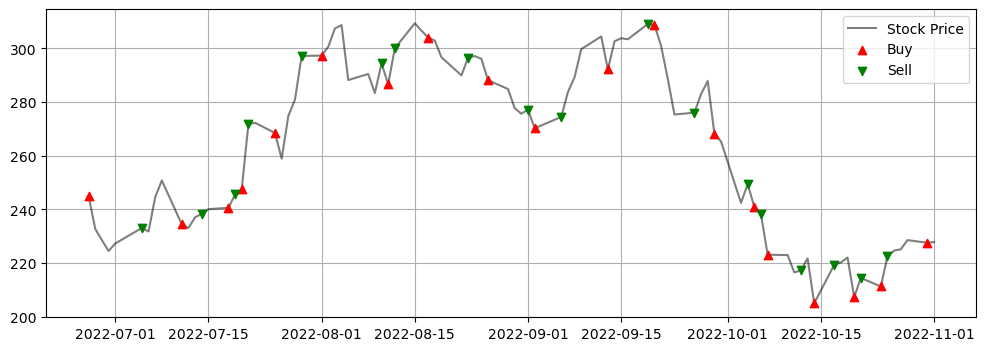

In [10]:
# plot the last 90 days
plt.figure(figsize=(12, 4))
df = stock.copy()
df["Buy"] = np.nan
df.loc[buy_dates, "Buy"] = df.loc[buy_dates, "Close"]
df["Sell"] = np.nan
df.loc[sell_dates, "Sell"] = df.loc[sell_dates, "Close"]
plt.plot(df["Close"], label="Stock Price", color="k", alpha=0.5)
plt.scatter(
    df.index, df["Buy"],
    marker="^", color="r", zorder=2,
    label="Buy"
)
plt.scatter(
    df.index, df["Sell"],
    marker="v", color="g", zorder=2,
    label="Sell"
)
plt.legend()
plt.grid()
plt.show()

As we can see, this strategy suggests to trade more often than that of the moving average approach. And, it tends to seize every opportunity to increase the profit.

## Profit

Use the `calc_profit` function from our `profit` module to calculate the profit rate:

In [11]:
profit_rate = profit.calc_profit(
    stock, 
    buy_dates, sell_dates, 
    start_date="2022-06-27"
)

print(f"Profit rate: {100 * profit_rate:.2f}%")

Profit rate: 17.05%


Recall the profit rate with moving average strategy is 9.19%. Hence, the strategy proposed in this section is somewhat better.